In [1]:
import keras
import sqlite3
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow import data as tf_data

In [2]:
CLASS_MAP = {"A": 0, "B": 1, "C": 2, "D": 3, "E": 4, "F": 5, "G": 6}

def parse_dataset():
    connection = sqlite3.connect("../backend/database.sqlite")

    train_class = []
    train_lat = []
    train_long = []
    train_day = []

    test_class = []
    test_lat = []
    test_long = []
    test_day = []

    fires = connection.cursor().execute(
        "SELECT FIRE_SIZE_CLASS, LATITUDE, LONGITUDE, DISCOVERY_DOY FROM Fires",
    ).fetchall()

    i = 0
    train_cutoff = round(len(fires) * 0.8)
    for fire in tqdm(fires):
        i+= 1
        label, lat, long, day = fire
        label = CLASS_MAP[label]
        day = day / 366
        if i < train_cutoff:
            train_class.append(label)
            train_lat.append(lat)
            train_long.append(long)
            train_day.append(day)
        else:
            test_class.append(label)
            test_lat.append(lat)
            test_long.append(long)
            test_day.append(day)

    return (
        (np.array(train_lat), np.array(train_long), np.array(train_day)),
        (np.array(test_lat), np.array(test_long), np.array(test_day)),
        np.array(train_class),
        np.array(test_class),
    )

In [3]:
NUM_CLASSES=7
BATCH_SIZE=256

(train_inputs, test_inputs, train_labels, test_labels) = parse_dataset()
train_lat, train_long, train_day = train_inputs
test_lat, test_long, test_day = test_inputs

100%|██████████| 1880465/1880465 [00:00<00:00, 2272563.84it/s]


In [4]:
dataset = tf_data.Dataset.from_tensor_slices(
    ((train_lat, train_long, train_day), train_labels)
)
dataset = dataset.shuffle(buffer_size=1024)
train_size = int(len(dataset) * 0.8)
validation_size = int(len(dataset) * 0.2)
train_dataset = dataset.take(train_size).batch(BATCH_SIZE)
validation_dataset = dataset.skip(train_size).take(validation_size).batch(BATCH_SIZE)

test_dataset = tf_data.Dataset.from_tensor_slices(
    ((test_lat, test_long, test_day), test_labels)
)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [5]:
input_latitude = keras.Input(shape=(1,), name='latitude')
input_longitude = keras.Input(shape=(1,), name='longitude')
input_day = keras.Input(shape=(1,), name='day_of_year')

day_embedding = keras.layers.Embedding(input_dim=366, output_dim=10)(input_day)
day_embedding = keras.layers.Flatten()(day_embedding)

concatenated_inputs = keras.layers.Concatenate()([input_latitude, input_longitude, day_embedding])

x = keras.layers.Dense(128, activation="relu")(concatenated_inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.5)(x)

output = keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)

# Build and compile model
model = keras.Model(inputs=[input_latitude, input_longitude, input_day], outputs=output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ day_of_year         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 10)     │      3,660 │ day_of_year[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ latitude            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ longitude           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 10)        │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 12)        │          0 │ latitude[0][0],   │
│ (Concatenate)       │                   │            │ longitude[0][0],  │
│                     │                   │            │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      1,664 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128)       │        512 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 7)         │        455 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,803 (57.82 KB)

 Trainable params: 14,419 (56.32 KB)

 Non-trainable params: 384 (1.50 KB)

In [6]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

history = model.fit(train_dataset, epochs=20, validation_data=validation_dataset)

Epoch 1/20


4702/4702 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 1.2737 - sparse_categorical_accuracy: 0.5261 - val_loss: 1.0931 - val_sparse_categorical_accuracy: 0.3533
Epoch 2/20
4702/4702 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 1.0490 - sparse_categorical_accuracy: 0.5699 - val_loss: 1.0546 - val_sparse_categorical_accuracy: 0.5236
Epoch 3/20
4702/4702 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 1.0502 - sparse_categorical_accuracy: 0.5658 - val_loss: 1.0540 - val_sparse_categorical_accuracy: 0.5625
Epoch 4/20
4702/4702 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 1.0530 - sparse_categorical_accuracy: 0.5612 - val_loss: 1.0445 - val_sparse_categorical_accuracy: 0.5520
Epoch 5/20
4702/4702 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 1.0531 - sparse_categorical_accuracy: 0.5601 - val_loss: 1.0469 - val_sparse_categorical_accuracy: 0.5385
Epoch 6/20
4702/4702 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 1.0533 - sparse_categorical_accuracy: 0.5584 - val_loss: 1.0482 - val_sparse_categorical_accuracy: 0.53

In [7]:
model.save("model.keras")
model.save("model.h5")

/var/folders/rw/b9js29716tj3qb0gm18586k00000gn/T/ipykernel_74469/1937279587.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(
/var/folders/rw/b9js29716tj3qb0gm18586k00000gn/T/ipykernel_74469/1937279587.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(
/var/folders/rw/b9js29716tj3qb0gm18586k00000gn/T/ipykernel_74469/1937279587.py:41: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(
/var/folders/rw/b9js29716tj3qb0gm18586k00000gn/T/ipykernel_74469/1937279587.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1

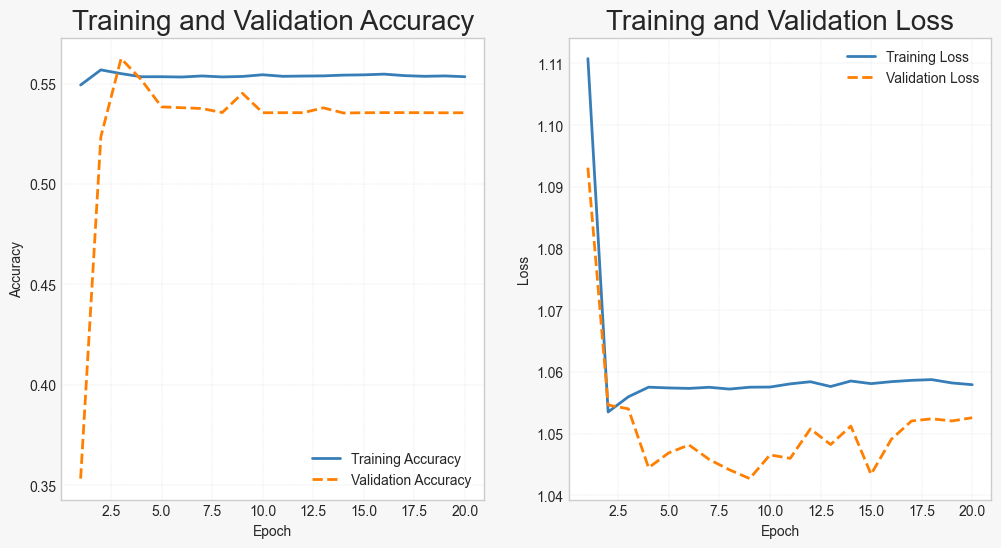

In [8]:
acc = history.history["sparse_categorical_accuracy"]
val_acc = history.history["val_sparse_categorical_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)

plt.style.use("seaborn-v0_8-whitegrid")
colors = ["#377eb8", "#ff7f00"]
linestyles = ["-", "--"]

fig = plt.figure(figsize=(12, 6))
fig.patch.set_facecolor("#f7f7f7")

plt.subplot(1, 2, 1)
plt.title("Training and Validation Accuracy", fontsize=20)
plt.plot(
    epochs,
    acc,
    "r",
    label="Training Accuracy",
    linestyle=linestyles[0],
    color=colors[0],
    linewidth=2,
)
plt.plot(
    epochs,
    val_acc,
    "b",
    label="Validation Accuracy",
    linestyle=linestyles[1],
    color=colors[1],
    linewidth=2,
)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True, linestyle="--", linewidth=0.2)

plt.subplot(1, 2, 2)
plt.title("Training and Validation Loss", fontsize=20)
plt.plot(
    epochs,
    loss,
    "r",
    label="Training Loss",
    linestyle=linestyles[0],
    color=colors[0],
    linewidth=2,
)
plt.plot(
    epochs,
    val_loss,
    "b",
    label="Validation Loss",
    linestyle=linestyles[1],
    color=colors[1],
    linewidth=2,
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.grid(True, linestyle="--", linewidth=0.2)

plt.savefig("training-and-validation-accuracy-and-loss.png")
plt.show()

In [9]:
model.evaluate(test_dataset)

1470/1470 ━━━━━━━━━━━━━━━━━━━━ 1s 724us/step - loss: 1.1047 - sparse_categorical_accuracy: 0.5253


[1.0728811025619507, 0.5078783631324768]